# Group the Data

#### 1 - Import Modules and Data
#### 2 - Assign buildings to lat/long rounded to the nearest x meters
####   


### Import Modules and Data


In [6]:
from tqdm import tqdm_notebook as tqdm
from shapely.geometry import Polygon, mapping
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import shapely.geometry
import geopandas as gpd
import pandas as pd
import random
import rasterio
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')

In [14]:
# Set Main Directories
project_folder = '../'
data_folder = project_folder + '1_data/'
# Identify Local Data Sources
lights = ('light', data_folder + 'NASA_NightLights/Cropped.tif')
pop = ('pop', data_folder + 'NASA_GriddedPop'\
               '/gpw-v4-population-count-rev10_2015_30_sec_tif'\
               '/Cropped_pop.tif')
analyset = [lights, pop]
analyvars = [x for x,y in analyset]

In [8]:
# Turn on Graphs? If true graphs will be created
# (will work, just slows it down)
graphs_on = True

In [9]:
# Start the clock
start_time = time.time()

### Get Data - CSV Verion

In [10]:
states = [('Oregon','OR'),('California','CA'), ('Washington','WA')]

In [11]:
i = 0
# Load Building Coordinates
for state,_ in states:
    if i == 0:
        bldngs = pd.read_csv(data_folder \
                             + 'states_csv/' + state + '.csv')\
                    .drop(columns=['Unnamed: 0'])
        bldngs['state'] = state_abbv
    else:
        df = pd.read_csv(data_folder \
                         + 'states_csv/' + state + '.csv')\
                .drop(columns=['Unnamed: 0'])
        df['state'] = state_abbv
        bldngs = bldngs.append(df)
    i += 1
    
# Add Cluster Assignments
clusters = pd.read_csv(data_folder + 'regions/cluster_assignments.csv')
bldngs = pd.merge(bldngs, clusters, on = ['latitude','longitude'])\
            .drop(columns=['Unnamed: 0'])
del clusters

print "Columns: " + str(bldngs.columns.tolist())
print "Buildings: " + "{:,}".format(len(bldngs))

Columns: ['area', 'latitude', 'longitude', 'cluster_k5']
Buildings: 8,555,103


### Add Light and Pop

In [12]:
def get_tiff_vals(file):
    vals = []
    with rasterio.open(file) as src:
        for val in tqdm(src.sample(zip(bldngs['longitude']\
                                         ,bldngs['latitude']))):
            vals.append(val[0])
        return vals

In [15]:
# Average pop and light, from tiffs, to df
for title, file in analyset:
    print "Loading " + str(title) + " vals..."
    bldngs[title] = get_tiff_vals(file)

try:
    bldngs.drop(columns=['Unnamed: 0'], inplace=True)
except:
    pass

Loading light vals...



Loading pop vals...


In [16]:
# Resolve pop negatives -> Replace with zerop
try:
    if len(bldngs['pop'][bldngs['pop']<0]) > 0:
        bldngs['pop'].mask(bldngs['pop'] < 0, 0, inplace=True)
except:
    print "Did not resolve population negatives"

In [17]:
# Average pixel-level vals of pop and light, across buildings
for col in analyvars:
    bldngs['count'] = 1
    df = bldngs[[col, 'count']]\
            .groupby([col]).count()\
            .reset_index()
    df['bldngval_' + col] = df[col]/df['count']
    bldngs = pd.merge(bldngs, df[[col, 'bldngval_' + col]] \
                            , on = [col], how = 'inner')\
                    .drop(columns=['count'])

In [18]:
bldngs.head()

,area,latitude,longitude,cluster_k5,light,pop,bldngval_light,bldngval_pop
0,216.4498,44.967206,-123.152603,1,2.126425,11.873093,0.303775,0.989424
1,131.0510,44.968993,-123.153729,1,2.126425,11.873093,0.303775,0.989424
2,211.7569,44.967517,-123.152829,1,2.126425,11.873093,0.303775,0.989424
3,425.5286,44.967578,-123.157177,1,1.684563,11.873093,0.084228,0.989424
4,407.0167,44.970268,-123.155134,1,1.684563,11.873093,0.084228,0.989424


### Make Groups

In [19]:
# Create Pixel Groups
for place in ['lat','long']:
    bldngs['group_' + str(place)] = bldngs[str(place) + 'itude']\
                            .apply(lambda x: round(x / 0.001) * 0.001)
bldngs['count'] = 1
bldngs_grps = bldngs.drop(columns=['latitude','longitude'])\
                          .groupby(['group_long', 'group_lat'])\
                            .sum()\
                            .sort_values(by='count', ascending=True)\
                            .reset_index()

# Define clusters from mode of the constitutent buildings
bldngs_grps['cluster_k5'] = (bldngs_grps['cluster_k5']\
                                /bldngs_grps['count']).astype(int)

In [20]:
print 'Largest group: ' + "{:,}".format(bldngs_grps['count'].max())
print 'Number of groups: ' + "{:,}".format(len(bldngs_grps))
print bldngs_grps[['count', 'area']].describe(percentiles=[.5, .75, .95])
bldngs_grps[-3:]

Largest group: 35
Number of groups: 2,969,435
              count          area
count  2.969435e+06  2.969435e+06
mean   2.881054e+00  1.343728e+03
std    2.620368e+00  2.815203e+03
min    1.000000e+00  8.427700e+00
50%    2.000000e+00  8.450465e+02
75%    4.000000e+00  1.747441e+03
95%    8.000000e+00  3.471723e+03
max    3.500000e+01  1.290801e+06


,group_long,group_lat,area,cluster_k5,light,pop,bldngval_light,bldngval_pop,count
2969432,-116.437,33.922,5344.5947,0,203.996841,43530.695312,0.883103,79.726548,32
2969433,-120.400,34.863,5819.4034,0,234.487991,21536.581848,1.111317,112.462008,34
2969434,-116.192,33.725,3142.7248,0,1635.151176,11362.926319,7.017816,44.707538,35


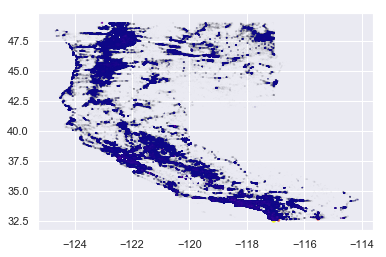

In [21]:
# Graph pop light
if graphs_on:
    plt.scatter(bldngs_grps['group_long'], bldngs_grps['group_lat'] \
                , s = ((bldngs_grps['bldngval_pop']+1)**2)/(10**6) \
                , c = bldngs_grps['bldngval_pop'] \
                , cmap = 'plasma', alpha = 1) 

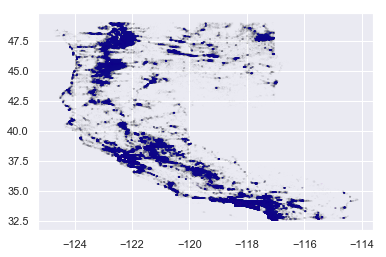

In [22]:
# Graph building light
if graphs_on:
    plt.scatter(bldngs_grps['group_long'], bldngs_grps['group_lat'] \
                , s = ((bldngs_grps['bldngval_light']+1)**2)/(10**6) \
                , c = bldngs_grps['bldngval_light'] \
                , cmap = 'plasma', alpha = 1) 

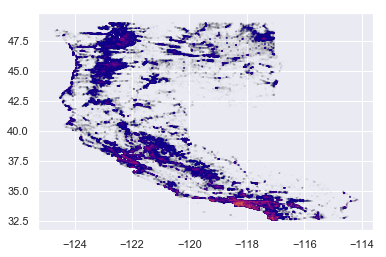

In [23]:
# graph building count
if graphs_on:
    plt.scatter(bldngs_grps['group_long'], bldngs_grps['group_lat'] \
                , s = ((bldngs_grps['count']+1)**2)/(10**6) \
                , c = bldngs_grps['count'] \
                , cmap = 'plasma', alpha = 1) 

In [26]:
stop_time = time.time()
print 'This notebook took ' \
        + str(int((stop_time-start_time)/60/60)) + ' Hours ' \
        + str(int((stop_time-start_time) % 60)) + ' Minutes ' \
        + 'and ' + str(int(stop_time-start_time) % 60) + ' Seconds'

This notebook took 8 Hours 26 Minutes and 26 Seconds


In [25]:
bldngs_grps.to_csv(data_folder + "bldng_groups.csv")
bldngs.to_csv(data_folder + "bldngs.csv")